In [2]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import torch.optim as optim
# import torch.optim.lr_scheduler as lr_scheduler
# from torch.optim.lr_scheduler import _LRScheduler
# import torch.utils.data as data
import numpy as np
np.set_printoptions(suppress=True)
# import openslide as ops

# import torchvision.transforms as transforms
# import torchvision.datasets as datasets
# import torchvision.models as models
import pydot
from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from fastprogress import progress_bar
import copy
from collections import namedtuple
import os
import random
import shutil
import time
from PIL import Image,ImageDraw,ImageEnhance,ImageColor 
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model

import pandas as pd
import tensorflow as tf
from tensorflow import keras
import keras_efficientnet_v2
import cv2
# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.keras.utils.multi_gpu_utils import multi_gpu_model
# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession
# #from tensorflow import ConfigProto
# #from tensorflow import InteractiveSession
# config = ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = "2"

Image.MAX_IMAGE_PIXELS = 10000000000
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [3]:
def timebase_get_file_list(file_path):
    dir_list = os.listdir(file_path)
    if not dir_list:
        return
    else:
        dir_list = sorted(dir_list,key=lambda x: os.path.getmtime(os.path.join(file_path, x)))
        return dir_list
def namebase_get_file_list(file_path):
    dir_list = os.listdir(file_path)
    if not dir_list:
        return
    else:
        dir_list = sorted(dir_list)
        return dir_list

def detection_3d(model1,test_img):

    timg = Image.fromarray((test_img))
    timg1 = np.array(timg)
    
    testarray = [[] for i in range(4)]
    testarray[0] = timg1 #原图
    testarray[1] = (np.flip(timg1,0))
    testarray[2] = np.rollaxis(timg1,0,2)
    testarray[3] = (np.rot90(timg1,2))
    
    testarray = np.asarray(testarray)
    
    aa = modeleva_3d(model1,testarray)
#     bb= aa[0]
#     bb[0] = np.average(aa[...,0])
#     bb[1] = np.average(aa[...,1])
#     bb[2] = np.average(aa[...,2])
#     bb[3] = np.average(aa[...,3])
#     return aa
    return np.average(aa[:,0]),np.average(aa[:,1])
#     return np.average(aa)

def modeleva_3d(model,test_img):
    test_img = np.asarray(test_img,dtype= np.float32)/255
    return model.predict(test_img)

In [4]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from keras_vis.gradcam_plus_plus import GradcamPlusPlus
from keras_vis.utils.model_modifiers import ReplaceToLinear
from keras_vis.utils.scores import CategoricalScore
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.vgg16 import preprocess_input
from keras_vis.scorecam import Scorecam
from keras_vis.gradcam import Gradcam
from keras_vis.saliency import Saliency
from keras_vis.gradcam_plus_plus import GradcamPlusPlus
data_array = np.load('./train/test/data_array.npy',allow_pickle=True)

In [ ]:
model_path = 'EfficientNetV2B2_bad1' #Xception
# model_path = 'vgg16_bad2' #Xception
model_id = 50

all_patch_list = namebase_get_file_list('./result/' + str(model_path))
model_name = [s for s in np.asarray(all_patch_list) if (str(model_id)+'-') in s][0]
model1 = keras.models.load_model('./result/' + str(model_path) + '/' + model_name)
# model2 = keras.models.load_model('./result/' + str(model_path) + '/' + model_name)

# if(os.path.isdir('./result/' + str(model_path) + '/cam_' + str(model_id) + '/') == False):
#     os.mkdir('./result/' + str(model_path) + '/cam_' + str(model_id) + '/')
# if(os.path.isdir('./result/' + str(model_path) + '/camplus_' + str(model_id) + '/') == False):
#     os.mkdir('./result/' + str(model_path) + '/camplus_' + str(model_id) + '/')
# if(os.path.isdir('./result/' + str(model_path) + '/scorecam_' + str(model_id) + '/') == False):
#     os.mkdir('./result/' + str(model_path) + '/scorecam_' + str(model_id) + '/')

In [5]:
from keras_vis.utils.model_modifiers import ReplaceToLinear

replace2linear = ReplaceToLinear()

# Instead of using the ReplaceToLinear instance above,
# you can also define the function from scratch as follows:
def model_modifier_function(cloned_model):
    cloned_model.layers[-1].activation = tf.keras.activations.linear

In [6]:
from keras_vis.utils.scores import CategoricalScore

# 1 is the imagenet index corresponding to Goldfish, 294 to Bear and 413 to Assault Rifle.
score0 = CategoricalScore([0, 0, 0, 0])
score1 = CategoricalScore([1, 1, 1, 1])
# Instead of using CategoricalScore object,
# you can also define the function from scratch as follows:
# def score_function(output):
#     # The `output` variable refers to the output of the model,
#     # so, in this case, `output` shape is `(3, 1000)` i.e., (samples, classes).
#     return (output[0][1], output[1][1], output[2][1], output[3][1])

In [7]:
gc = Gradcam(model1,
                  model_modifier=replace2linear,
                  clone=True)

gcpp = GradcamPlusPlus(model1,
                  model_modifier=replace2linear,
                  clone=True)

# sc = Scorecam(model, model_modifier=replace2linear)

In [8]:
from keras.backend import set_session
from keras.backend import clear_session
from keras.backend import get_session

def gradcam_3d(X, score, Layer):

    # Generate heatmap with GradCAM
    cam = gc(score,
                  X,
                  penultimate_layers=Layer, seek_penultimate_conv_layer=seek)
    
    aa = copy.deepcopy((images)*0.)       
    aa[0] = np.uint8(cm.jet(cam[0])[..., :3] * 255)
    aa[1] = np.flip((np.uint8(cm.jet(cam[1])[..., :3] * 255)),0)   
    aa[2] = np.rollaxis(np.uint8(cm.jet(cam[2])[..., :3] * 255),0,2)
    aa[3] = np.rot90((np.uint8(cm.jet(cam[3])[..., :3] * 255)),2)
    
    temp_cam_all = aa[0] + aa[1] + aa[2]  + aa[3]
    return temp_cam_all

def gradcamplusplus_3d(X, score, Layer):

    # Generate heatmap with GradCAM
    cam = gcpp(score,
                  X,
                  penultimate_layers=Layer, seek_penultimate_conv_layer=seek)
    
    aa = copy.deepcopy((images)*0.)       
    aa[0] = np.uint8(cm.jet(cam[0])[..., :3] * 255)
    aa[1] = np.flip((np.uint8(cm.jet(cam[1])[..., :3] * 255)),0)   
    aa[2] = np.rollaxis(np.uint8(cm.jet(cam[2])[..., :3] * 255),0,2)
    aa[3] = np.rot90((np.uint8(cm.jet(cam[3])[..., :3] * 255)),2)
    sequential
    temp_cam_all = aa[0] + aa[1] + aa[2]  + aa[3]
    return temp_cam_all

def scorecam_3d(X,score):

    cam = sc(score,
                   X,
                   penultimate_layer=layer,
                   max_N=10)
    
    aa = copy.deepcopy((images)*0.)       
    aa[0] = np.uint8(cm.jet(cam[0])[..., :3] * 255)
    aa[1] = np.flip((np.uint8(cm.jet(cam[1])[..., :3] * 255)),0)   
    aa[2] = np.rollaxis(np.uint8(cm.jet(cam[2])[..., :3] * 255),0,2)
    aa[3] = np.rot90((np.uint8(cm.jet(cam[3])[..., :3] * 255)),2)
    
    temp_cam_all = aa[0] + aa[1] + aa[2]  + aa[3]
    return temp_cam_all       
    

In [10]:
plot_model(model1,show_shapes=True)

In [18]:
model1.layers[-15:-5]

In [16]:
model1.summary()

Model: "resnet152"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
__________________________________________________________________________________________

In [17]:
model1.layers[-8] is tf.keras.layers.Layer

False

In [13]:
model1.layers[-21:-20][0]

In [33]:
a = gc(seed_input=X,score = score1,penultimate_layers=range(-21,-7), seek_penultimate_conv_layer=False)

In [34]:
a= np.asarray(a)

(-0.5, 255.5, 255.5, -0.5)

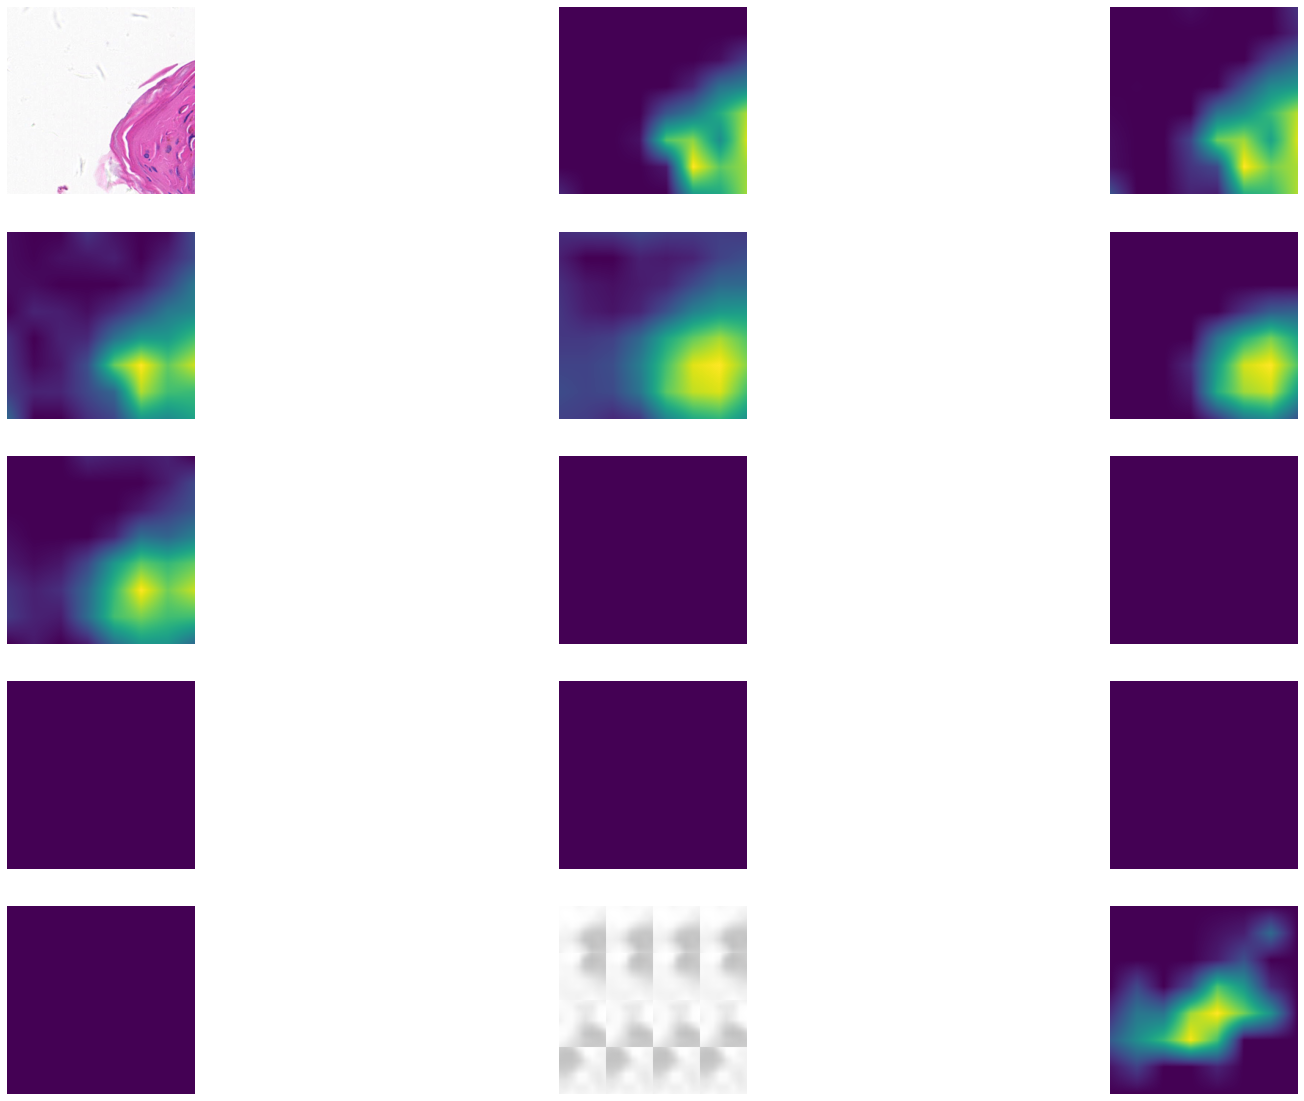

In [46]:
f, ax = plt.subplots(nrows=5, ncols=3, figsize=(28, 20))
ax[0,0].imshow(X[0])
ax[0,0].axis('off')
ax[0,1].imshow(a[0,0])
ax[0,1].axis('off')
ax[0,2].imshow(a[1,0])
ax[0,2].axis('off')
ax[1,0].imshow(a[2,0])
ax[1,0].axis('off')
ax[1,1].imshow(a[3,0])
ax[1,1].axis('off')
ax[1,2].imshow(a[4,0])
ax[1,2].axis('off')
ax[2,0].imshow(a[5,0])
ax[2,0].axis('off')
ax[2,1].imshow(a[6,0])
ax[2,1].axis('off')
ax[2,2].imshow(a[7,0])
ax[2,2].axis('off')
ax[3,0].imshow(a[8,0])
ax[3,0].axis('off')
ax[3,1].imshow(a[9,0])
ax[3,1].axis('off')
ax[3,2].imshow(a[10,0])
ax[3,2].axis('off')
ax[4,0].imshow(a[11,0])
ax[4,0].axis('off')
ax[4,1].imshow(np.average(a,axis=0).reshape((256,256,4)))
ax[4,1].axis('off')
ax[4,2].imshow(a[13,0])
ax[4,2].axis('off')

In [42]:
a.shape

(14, 4, 256, 256)

In [43]:
np.average(a,axis=0).shape

(4, 256, 256)

In [ ]:
gradcam_3d(X, score0, layer)

In [9]:
layer = range(-21,-7)
seek = False

In [10]:
patch_size = 256
overlap = 128
print(model_path, ' --> ', layer, '     seek = ' ,seek)

# for types,mask_id in progress_bar([(1,1),(1,3),(1,4),(4,1),(4,2),(4,3),(4,4),(4,5),(7,1),(7,4)]):
for types,mask_id in progress_bar([(7,1)]):

        
    if(os.path.exists(r'./train/test/' + str(types) + '/svs/' + str(types) + '_' + str(mask_id) + r'.svs')==True):

#             tif = ops.open_slide(r'./train/test/' + str(types) + '/svs/' + str(types) + '_' + str(mask_id) + r'.svs')

        god_img_mask = copy.deepcopy(np.asarray(Image.open(r'./train/test/' + str(types) + '/svs/' + str(types) + '_' + str(mask_id) + r'_good.png')))
        god_img_mask = cv2.resize(god_img_mask, (god_img_mask.shape[1]//2,god_img_mask.shape[0]//2),interpolation = cv2.INTER_AREA    )

#             bad_img_mask = copy.deepcopy(np.asarray(Image.open(r'./train/test/' + str(types) + '/svs/' + str(types) + '_' + str(mask_id) + r'_bad.png')))
#             bad_img_mask = cv2.resize(bad_img_mask, (god_img_mask.shape[1],god_img_mask.shape[0]),interpolation = cv2.INTER_AREA    )

        gc_result0 = np.zeros((god_img_mask.shape[0],god_img_mask.shape[1],3), dtype = np.float64)
        gc_result1 = copy.deepcopy(gc_result0)
        gcpp_result0 = copy.deepcopy(gc_result0)
        gcpp_result1 = copy.deepcopy(gc_result0)
#         sc_result = copy.deepcopy(gc_result)
        sub_mask    = copy.deepcopy(np.asarray(god_img_mask*0, dtype = np.uint8))


#             total_size = bad_img_mask.shape[1],bad_img_mask.shape[0]

        for temp_patch in progress_bar(data_array[types][mask_id]):
            test_img = temp_patch[2]
            x = temp_patch[0]//2
            y = temp_patch[1]//2
            
            timg1 = np.asarray(test_img)
            images = np.asarray([np.array(timg1), np.array(np.flip(timg1,0)), np.array(np.rollaxis(timg1,0,2)), np.array((np.rot90(timg1,2)))])
            X = images/255

            gc_result_temp0 = gradcam_3d(X, score0, layer)
            gc_result_temp1 = gradcam_3d(X, score1, layer)
#             gcpp_result_temp0 = gradcamplusplus_3d(X, score0, layer)
#             gcpp_result_temp1 = gradcamplusplus_3d(X, score1, layer)
#             sc_result_temp = scorecam_3d(X)

            gc_result0[y:y+patch_size,x:x+patch_size] += gc_result_temp0
            gc_result1[y:y+patch_size,x:x+patch_size] += gc_result_temp1
#             gcpp_result0[y:y+patch_size,x:x+patch_size] += gcpp_result_temp0
#             gcpp_result1[y:y+patch_size,x:x+patch_size] += gcpp_result_temp1
#             sc_result[y:y+patch_size,x:x+patch_size] += sc_result_temp            
            
            sub_mask[y:y+patch_size,x:x+patch_size] += 4
            
        sub_mask = (np.stack([sub_mask,sub_mask,sub_mask],2))
        sub_mask[sub_mask==0] = 1
        gc_result0 = gc_result0/sub_mask
        gc_result1 = gc_result1/sub_mask
        gcpp_result0 = gcpp_result0/sub_mask
        gcpp_result1 = gcpp_result1/sub_mask
#         sc_result = sc_result/sub_mask

        Image.fromarray(np.asarray(gc_result0,   dtype = np.uint8)).save('./result/' + str(model_path) + '/gc0_'   + str(types) + '_' + str(mask_id) + '.png')
        Image.fromarray(np.asarray(gc_result1,   dtype = np.uint8)).save('./result/' + str(model_path) + '/gc1_'   + str(types) + '_' + str(mask_id) + '.png')
#         Image.fromarray(np.asarray(gcpp_result0, dtype = np.uint8)).save('./result/' + str(model_path) + '/gcpp0_' + str(types) + '_' + str(mask_id) + '.png')
#         Image.fromarray(np.asarray(gcpp_result1, dtype = np.uint8)).save('./result/' + str(model_path) + '/gcpp1_' + str(types) + '_' + str(mask_id) + '.png')

EfficientNetV2B2_bad1  -->  range(-21, -7)      seek =  False


In [8]:
'./result/' + str(model_path) + '/cam_' + str(model_id) + '/' + str(1) + '_' + str(1)

'./result/vgg16_bad2/cam_50/1_1'

In [69]:
gradcam_mask2 = copy.deepcopy(gradcam_mask)

sub_mask[sub_mask==0] = 1

gradcam_mask2 = gradcam_mask2/(np.stack([sub_mask,sub_mask,sub_mask],2))

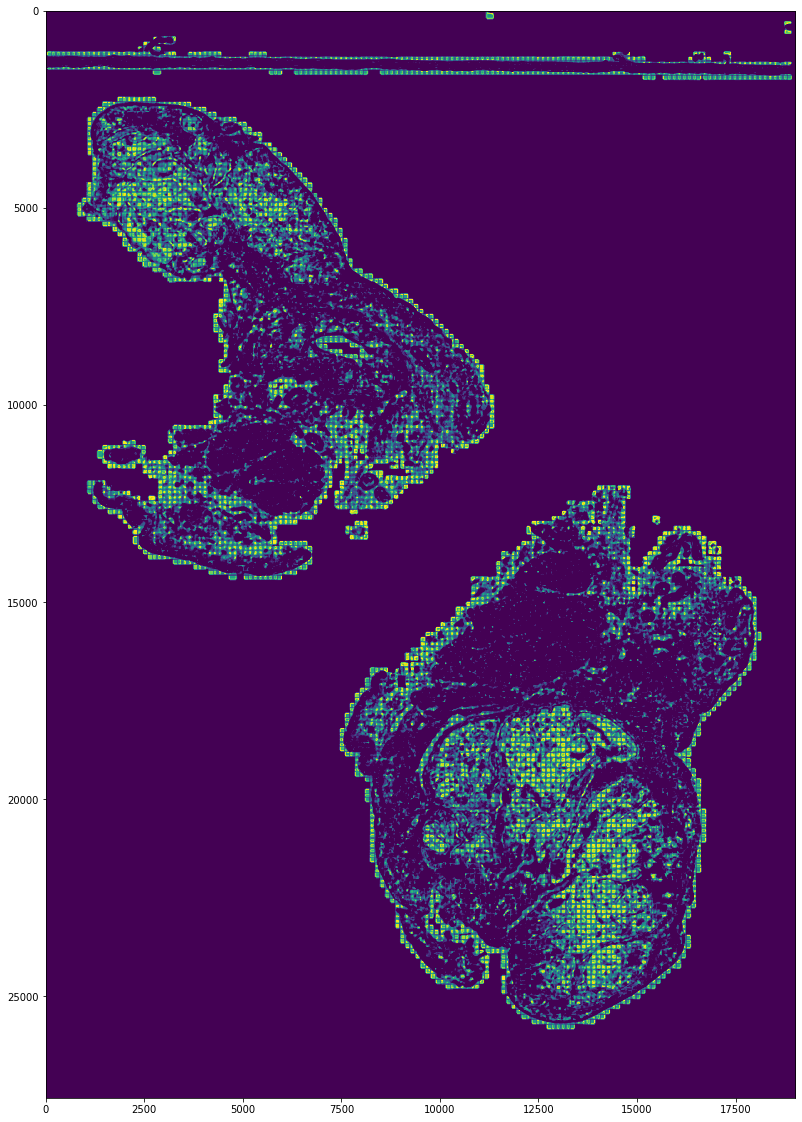

In [71]:
plt.figure(figsize=(30,20))
plt.imshow(gradcam_mask2[...,0], interpolation='nearest')
plt.show()

In [ ]:
np.save('./result/vgg16_bad1_50_' + str(types) + '_' + str(mask_id),  gradcam_mask2)

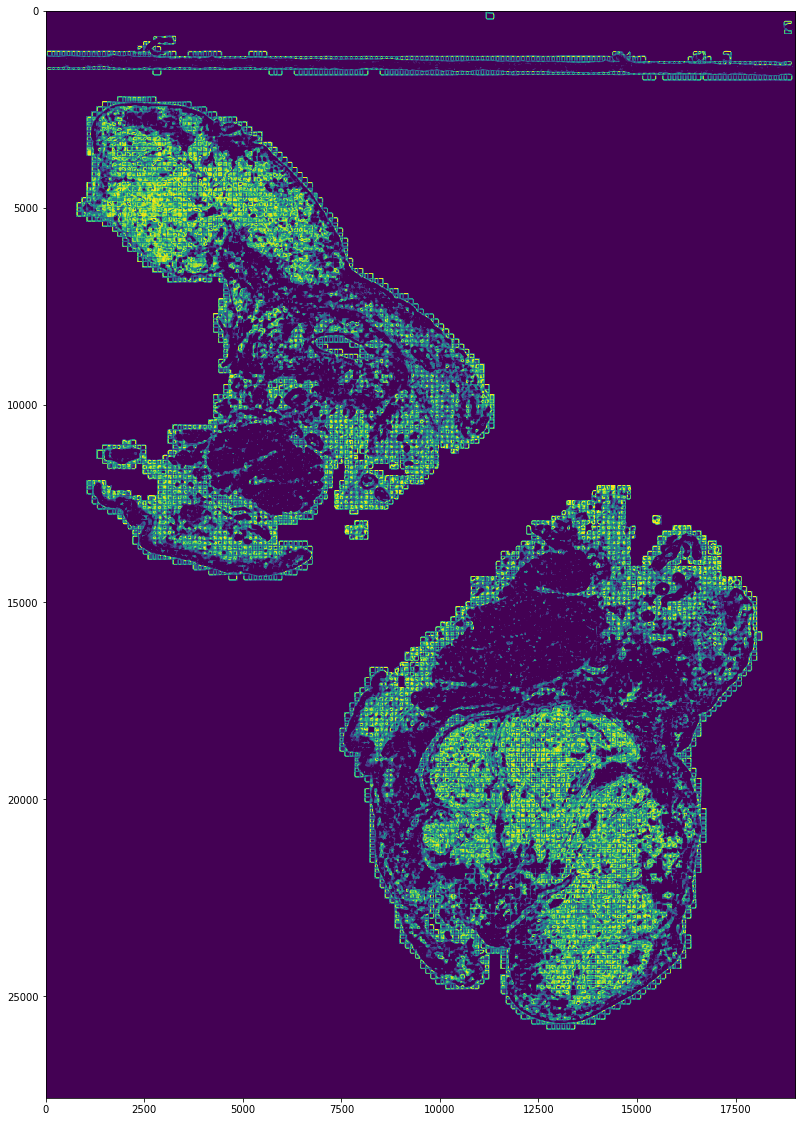

In [72]:
plt.figure(figsize=(30,20))
plt.imshow(gradcam_mask2[...,1], interpolation='nearest')
plt.show()

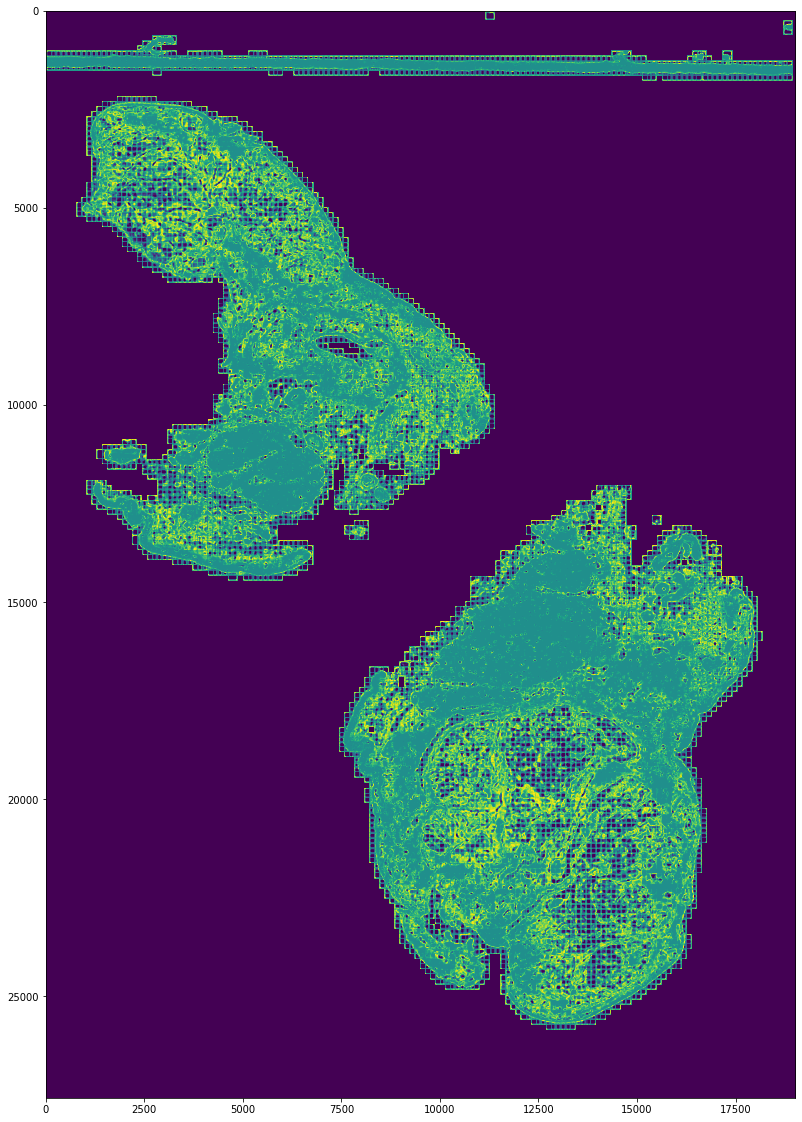

In [73]:
plt.figure(figsize=(30,20))
plt.imshow(gradcam_mask2[...,2], interpolation='nearest')
plt.show()

In [48]:
god_img_mask2 = copy.deepcopy(np.asarray(Image.open(r'./train/test/' + str(types) + '/svs/' + str(types) + '_' + str(mask_id) + r'_good.png')))

In [50]:
god_img_mask.shape

(19018, 27579)

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Conv2D, LayerNormalization, GlobalAveragePooling1D




class Mlp(tf.keras.layers.Layer):
    def __init__(self, in_features, hidden_features=None, out_features=None, drop=0., prefix=''):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = Dense(hidden_features, name=f'{prefix}/mlp/fc1')
        self.fc2 = Dense(out_features, name=f'{prefix}/mlp/fc2')
        self.drop = Dropout(drop)

    def call(self, x):
        x = self.fc1(x)
        x = tf.keras.activations.gelu(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


def window_partition(x, window_size):
    B, H, W, C = x.get_shape().as_list()
    x = tf.reshape(x, shape=[-1, H // window_size,
                   window_size, W // window_size, window_size, C])
    x = tf.transpose(x, perm=[0, 1, 3, 2, 4, 5])
    windows = tf.reshape(x, shape=[-1, window_size, window_size, C])
    return windows


def window_reverse(windows, window_size, H, W, C):
    x = tf.reshape(windows, shape=[-1, H // window_size,
                   W // window_size, window_size, window_size, C])
    x = tf.transpose(x, perm=[0, 1, 3, 2, 4, 5])
    x = tf.reshape(x, shape=[-1, H, W, C])
    return x


class WindowAttention(tf.keras.layers.Layer):
    def __init__(self, dim, window_size, num_heads, qkv_bias=True, qk_scale=None, attn_drop=0., proj_drop=0., prefix=''):
        super().__init__()
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5
        self.prefix = prefix

        self.qkv = Dense(dim * 3, use_bias=qkv_bias,
                         name=f'{self.prefix}/attn/qkv')
        self.attn_drop = Dropout(attn_drop)
        self.proj = Dense(dim, name=f'{self.prefix}/attn/proj')
        self.proj_drop = Dropout(proj_drop)

    def build(self, input_shape):
        self.relative_position_bias_table = self.add_weight(f'{self.prefix}/attn/relative_position_bias_table',
                                                            shape=(
                                                                (2 * self.window_size[0] - 1) * (2 * self.window_size[1] - 1), self.num_heads),
                                                            initializer=tf.initializers.Zeros(), trainable=True)

        coords_h = np.arange(self.window_size[0])
        coords_w = np.arange(self.window_size[1])
        coords = np.stack(np.meshgrid(coords_h, coords_w, indexing='ij'))
        coords_flatten = coords.reshape(2, -1)
        relative_coords = coords_flatten[:, :,
                                         None] - coords_flatten[:, None, :]
        relative_coords = relative_coords.transpose([1, 2, 0])
        relative_coords[:, :, 0] += self.window_size[0] - 1
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1).astype(np.int64)
        self.relative_position_index = tf.Variable(initial_value=tf.convert_to_tensor(
            relative_position_index), trainable=False, name=f'{self.prefix}/attn/relative_position_index')
        self.built = True

    def call(self, x, mask=None):
        B_, N, C = x.get_shape().as_list()
        qkv = tf.transpose(tf.reshape(self.qkv(
            x), shape=[-1, N, 3, self.num_heads, C // self.num_heads]), perm=[2, 0, 3, 1, 4])
        q, k, v = qkv[0], qkv[1], qkv[2]

        q = q * self.scale
        attn = (q @ tf.transpose(k, perm=[0, 1, 3, 2]))
        relative_position_bias = tf.gather(self.relative_position_bias_table, tf.reshape(
            self.relative_position_index, shape=[-1]))
        relative_position_bias = tf.reshape(relative_position_bias, shape=[
                                            self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], -1])
        relative_position_bias = tf.transpose(
            relative_position_bias, perm=[2, 0, 1])
        attn = attn + tf.expand_dims(relative_position_bias, axis=0)

        if mask is not None:
            nW = mask.get_shape()[0]  # tf.shape(mask)[0]
            attn = tf.reshape(attn, shape=[-1, nW, self.num_heads, N, N]) + tf.cast(
                tf.expand_dims(tf.expand_dims(mask, axis=1), axis=0), attn.dtype)
            attn = tf.reshape(attn, shape=[-1, self.num_heads, N, N])
            attn = tf.nn.softmax(attn, axis=-1)
        else:
            attn = tf.nn.softmax(attn, axis=-1)

        attn = self.attn_drop(attn)

        x = tf.transpose((attn @ v), perm=[0, 2, 1, 3])
        x = tf.reshape(x, shape=[-1, N, C])
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


def drop_path(inputs, drop_prob, is_training):
    if (not is_training) or (drop_prob == 0.):
        return inputs

    # Compute keep_prob
    keep_prob = 1.0 - drop_prob

    # Compute drop_connect tensor
    random_tensor = keep_prob
    shape = (tf.shape(inputs)[0],) + (1,) * \
        (len(tf.shape(inputs)) - 1)
    random_tensor += tf.random.uniform(shape, dtype=inputs.dtype)
    binary_tensor = tf.floor(random_tensor)
    output = tf.math.divide(inputs, keep_prob) * binary_tensor
    return output


class DropPath(tf.keras.layers.Layer):
    def __init__(self, drop_prob=None):
        super().__init__()
        self.drop_prob = drop_prob

    def call(self, x, training=None):
        return drop_path(x, self.drop_prob, training)


class SwinTransformerBlock(tf.keras.layers.Layer):
    def __init__(self, dim, input_resolution, num_heads, window_size=7, shift_size=0, mlp_ratio=4.,
                 qkv_bias=True, qk_scale=None, drop=0., attn_drop=0., drop_path_prob=0., norm_layer=LayerNormalization, prefix=''):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        if min(self.input_resolution) <= self.window_size:
            self.shift_size = 0
            self.window_size = min(self.input_resolution)
        assert 0 <= self.shift_size < self.window_size, "shift_size must in 0-window_size"
        self.prefix = prefix

        self.norm1 = norm_layer(epsilon=1e-5, name=f'{self.prefix}/norm1')
        self.attn = WindowAttention(dim, window_size=(self.window_size, self.window_size), num_heads=num_heads,
                                    qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop, prefix=self.prefix)
        self.drop_path = DropPath(
            drop_path_prob if drop_path_prob > 0. else 0.)
        self.norm2 = norm_layer(epsilon=1e-5, name=f'{self.prefix}/norm2')
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim,
                       drop=drop, prefix=self.prefix)

    def build(self, input_shape):
        if self.shift_size > 0:
            H, W = self.input_resolution
            img_mask = np.zeros([1, H, W, 1])
            h_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            w_slices = (slice(0, -self.window_size),
                        slice(-self.window_size, -self.shift_size),
                        slice(-self.shift_size, None))
            cnt = 0
            for h in h_slices:
                for w in w_slices:
                    img_mask[:, h, w, :] = cnt
                    cnt += 1

            img_mask = tf.convert_to_tensor(img_mask)
            mask_windows = window_partition(img_mask, self.window_size)
            mask_windows = tf.reshape(
                mask_windows, shape=[-1, self.window_size * self.window_size])
            attn_mask = tf.expand_dims(
                mask_windows, axis=1) - tf.expand_dims(mask_windows, axis=2)
            attn_mask = tf.where(attn_mask != 0, -100.0, attn_mask)
            attn_mask = tf.where(attn_mask == 0, 0.0, attn_mask)
            self.attn_mask = tf.Variable(
                initial_value=attn_mask, trainable=False, name=f'{self.prefix}/attn_mask')
        else:
            self.attn_mask = None

        self.built = True

    def call(self, x):
        H, W = self.input_resolution
        B, L, C = x.get_shape().as_list()
        assert L == H * W, "input feature has wrong size"

        shortcut = x
        x = self.norm1(x)
        x = tf.reshape(x, shape=[-1, H, W, C])

        # cyclic shift
        if self.shift_size > 0:
            shifted_x = tf.roll(
                x, shift=[-self.shift_size, -self.shift_size], axis=[1, 2])
        else:
            shifted_x = x

        # partition windows
        x_windows = window_partition(shifted_x, self.window_size)
        x_windows = tf.reshape(
            x_windows, shape=[-1, self.window_size * self.window_size, C])

        # W-MSA/SW-MSA
        attn_windows = self.attn(x_windows, mask=self.attn_mask)

        # merge windows
        attn_windows = tf.reshape(
            attn_windows, shape=[-1, self.window_size, self.window_size, C])
        shifted_x = window_reverse(attn_windows, self.window_size, H, W, C)

        # reverse cyclic shift
        if self.shift_size > 0:
            x = tf.roll(shifted_x, shift=[
                        self.shift_size, self.shift_size], axis=[1, 2])
        else:
            x = shifted_x
        x = tf.reshape(x, shape=[-1, H * W, C])

        # FFN
        x = shortcut + self.drop_path(x)
        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x


class PatchMerging(tf.keras.layers.Layer):
    def __init__(self, input_resolution, dim, norm_layer=LayerNormalization, prefix=''):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.reduction = Dense(2 * dim, use_bias=False,
                               name=f'{prefix}/downsample/reduction')
        self.norm = norm_layer(epsilon=1e-5, name=f'{prefix}/downsample/norm')

    def call(self, x):
        H, W = self.input_resolution
        B, L, C = x.get_shape().as_list()
        assert L == H * W, "input feature has wrong size"
        assert H % 2 == 0 and W % 2 == 0, f"x size ({H}*{W}) are not even."

        x = tf.reshape(x, shape=[-1, H, W, C])

        x0 = x[:, 0::2, 0::2, :]  # B H/2 W/2 C
        x1 = x[:, 1::2, 0::2, :]  # B H/2 W/2 C
        x2 = x[:, 0::2, 1::2, :]  # B H/2 W/2 C
        x3 = x[:, 1::2, 1::2, :]  # B H/2 W/2 C
        x = tf.concat([x0, x1, x2, x3], axis=-1)
        x = tf.reshape(x, shape=[-1, (H // 2) * (W // 2), 4 * C])

        x = self.norm(x)
        x = self.reduction(x)

        return x


class BasicLayer(tf.keras.layers.Layer):
    def __init__(self, dim, input_resolution, depth, num_heads, window_size,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path_prob=0., norm_layer=LayerNormalization, downsample=None, use_checkpoint=False, prefix=''):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth
        self.use_checkpoint = use_checkpoint

        # build blocks
        self.blocks = tf.keras.Sequential([SwinTransformerBlock(dim=dim, input_resolution=input_resolution,
                                           num_heads=num_heads, window_size=window_size,
                                           shift_size=0 if (
                                               i % 2 == 0) else window_size // 2,
                                           mlp_ratio=mlp_ratio,
                                           qkv_bias=qkv_bias, qk_scale=qk_scale,
                                           drop=drop, attn_drop=attn_drop,
                                           drop_path_prob=drop_path_prob[i] if isinstance(
                                               drop_path_prob, list) else drop_path_prob,
                                           norm_layer=norm_layer,
                                           prefix=f'{prefix}/blocks{i}') for i in range(depth)])
        if downsample is not None:
            self.downsample = downsample(
                input_resolution, dim=dim, norm_layer=norm_layer, prefix=prefix)
        else:
            self.downsample = None

    def call(self, x):
        x = self.blocks(x)

        if self.downsample is not None:
            x = self.downsample(x)
        return x


class PatchEmbed(tf.keras.layers.Layer):
    def __init__(self, img_size=(224, 224), patch_size=(4, 4), in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__(name='patch_embed')
        patches_resolution = [img_size[0] //
                              patch_size[0], img_size[1] // patch_size[1]]
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]

        self.in_chans = in_chans
        self.embed_dim = embed_dim

        self.proj = Conv2D(embed_dim, kernel_size=patch_size,
                           strides=patch_size, name='proj')
        if norm_layer is not None:
            self.norm = norm_layer(epsilon=1e-5, name='norm')
        else:
            self.norm = None

    def call(self, x):
        B, H, W, C = x.get_shape().as_list()
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        x = self.proj(x)
        x = tf.reshape(
            x, shape=[-1, (H // self.patch_size[0]) * (W // self.patch_size[0]), self.embed_dim])
        if self.norm is not None:
            x = self.norm(x)
        return x


class SwinTransformerModel(tf.keras.Model):
    def __init__(self, model_name='swin_tiny_patch4_window7_224', include_top=False,
                 img_size=(224, 224), patch_size=(4, 4), in_chans=3, num_classes=1000,
                 embed_dim=96, depths=[2, 2, 6, 2], num_heads=[3, 6, 12, 24],
                 window_size=7, mlp_ratio=4., qkv_bias=True, qk_scale=None,
                 drop_rate=0., attn_drop_rate=0., drop_path_rate=0.1,
                 norm_layer=LayerNormalization, ape=False, patch_norm=True,
                 use_checkpoint=False, **kwargs):
        super().__init__(name=model_name)

        self.include_top = include_top

        self.num_classes = num_classes
        self.num_layers = len(depths)
        self.embed_dim = embed_dim
        self.ape = ape
        self.patch_norm = patch_norm
        self.num_features = int(embed_dim * 2 ** (self.num_layers - 1))
        self.mlp_ratio = mlp_ratio

        # split image into non-overlapping patches
        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim,
            norm_layer=norm_layer if self.patch_norm else None)
        num_patches = self.patch_embed.num_patches
        patches_resolution = self.patch_embed.patches_resolution
        self.patches_resolution = patches_resolution

        # absolute postion embedding
        if self.ape:
            self.absolute_pos_embed = self.add_weight('absolute_pos_embed',
                                                      shape=(
                                                          1, num_patches, embed_dim),
                                                      initializer=tf.initializers.Zeros())

        self.pos_drop = Dropout(drop_rate)

        # stochastic depth
        dpr = [x for x in np.linspace(0., drop_path_rate, sum(depths))]

        # build layers
        self.basic_layers = tf.keras.Sequential([BasicLayer(dim=int(embed_dim * 2 ** i_layer),
                                                input_resolution=(patches_resolution[0] // (2 ** i_layer),
                                                                  patches_resolution[1] // (2 ** i_layer)),
                                                depth=depths[i_layer],
                                                num_heads=num_heads[i_layer],
                                                window_size=window_size,
                                                mlp_ratio=self.mlp_ratio,
                                                qkv_bias=qkv_bias, qk_scale=qk_scale,
                                                drop=drop_rate, attn_drop=attn_drop_rate,
                                                drop_path_prob=dpr[sum(depths[:i_layer]):sum(
                                                    depths[:i_layer + 1])],
                                                norm_layer=norm_layer,
                                                downsample=PatchMerging if (
                                                    i_layer < self.num_layers - 1) else None,
                                                use_checkpoint=use_checkpoint,
                                                prefix=f'layers{i_layer}') for i_layer in range(self.num_layers)])
        self.norm = norm_layer(epsilon=1e-5, name='norm')
        self.avgpool = GlobalAveragePooling1D()
        if self.include_top:
            self.head = Dense(num_classes, name='head')
        else:
            self.head = None

    def forward_features(self, x):
        x = self.patch_embed(x)
        if self.ape:
            x = x + self.absolute_pos_embed
        x = self.pos_drop(x)

        x = self.basic_layers(x)
        x = self.norm(x)
        x = self.avgpool(x)
        return x

    def call(self, x):
        x = self.forward_features(x)
        if self.include_top:
            x = self.head(x)
        return x


def SwinTransformer(model_name='swin_tiny_224', num_classes=2, include_top=True, pretrained=True, use_tpu=False, cfgs=CFGS):
    cfg = cfgs[model_name]
    net = SwinTransformerModel(
        model_name=model_name, include_top=include_top, num_classes=num_classes, img_size=cfg['input_size'], window_size=cfg[
            'window_size'], embed_dim=cfg['embed_dim'], depths=cfg['depths'], num_heads=cfg['num_heads']
    )
    net(tf.keras.Input(shape=(cfg['input_size'][0], cfg['input_size'][1], 3)))
    if pretrained is True:
        url = f'https://github.com/rishigami/Swin-Transformer-TF/releases/download/v0.1-tf-swin-weights/{model_name}.tgz'
        pretrained_ckpt = tf.keras.utils.get_file(
            model_name, url, untar=True)
    else:
        pretrained_ckpt = pretrained

    if pretrained_ckpt:
        if tf.io.gfile.isdir(pretrained_ckpt):
            pretrained_ckpt = f'{pretrained_ckpt}/{model_name}.ckpt'

#     net.load_weights(pretrained_ckpt)

    return net

In [34]:
SwinTransformerModel

__main__.SwinTransformerModel

In [8]:
model = tf.keras.Sequential([
  tf.keras.layers.Lambda(lambda data: tf.keras.applications.imagenet_utils.preprocess_input(tf.cast(data, tf.float32), mode="torch"), input_shape=[256,256, 3]),
  SwinTransformer('swin_tiny_256', num_classes=2, include_top=True, pretrained=False),
  tf.keras.layers.Dense(2, activation='softmax')
])

In [41]:
net(tf.keras.Input(shape = (256,256, 3)))

<KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'swin_tiny_256')>

In [6]:
CFGS = {
    'swin_tiny_224': dict(input_size=(224, 224), window_size=7, embed_dim=96, depths=[2, 2, 6, 2], num_heads=[3, 6, 12, 24]),
    'swin_tiny_256': dict(input_size=(256, 256), window_size=8, embed_dim=96, depths=[2, 2, 6, 2], num_heads=[3, 6, 12, 24]),    
    'swin_small_224': dict(input_size=(224, 224), window_size=7, embed_dim=96, depths=[2, 2, 18, 2], num_heads=[3, 6, 12, 24]),
    'swin_base_224': dict(input_size=(224, 224), window_size=7, embed_dim=128, depths=[2, 2, 18, 2], num_heads=[4, 8, 16, 32]),
    'swin_base_384': dict(input_size=(384, 384), window_size=12, embed_dim=128, depths=[2, 2, 18, 2], num_heads=[4, 8, 16, 32]),
    'swin_large_224': dict(input_size=(224, 224), window_size=7, embed_dim=192, depths=[2, 2, 18, 2], num_heads=[6, 12, 24, 48]),
    'swin_large_384': dict(input_size=(384, 384), window_size=12, embed_dim=192, depths=[2, 2, 18, 2], num_heads=[6, 12, 24, 48])
}

In [47]:
model = SwinTransformer('swin_tiny_256', num_classes=2, include_top=True, pretrained=False)


In [12]:
from tfswin import SwinTransformerTiny224

ModuleNotFoundError: No module named 'tfswin'

In [31]:
from keras import layers, models
from tfswin import SwinTransformerTiny224, preprocess_input

inputs = layers.Input(shape=(256, 256, 3), dtype='uint8')
outputs = layers.Lambda(preprocess_input)(inputs)
outputs = SwinTransformerTiny224(pretrain_size=256,include_top=True,window_size=8,weights=None)(outputs)
outputs = layers.Dense(2, activation='softmax')(outputs)
model = models.Model(inputs=inputs, outputs=outputs)

In [39]:
model.compile(optimizer=keras.optimizers.Adam(0.00005),
              loss=tf.keras.losses.CategoricalCrossentropy(),
#                   loss=tf.keras.losses.BinaryCrossentropy(),
#                   loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])

In [33]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 256, 256, 3)]     0         
_________________________________________________________________
lambda_8 (Lambda)            (None, 256, 256, 3)       0         
_________________________________________________________________
swin_tiny_224 (Functional)   (None, 1000)              28296082  
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 2002      
Total params: 28,298,084
Trainable params: 28,298,084
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.layers[2].layers[-1]

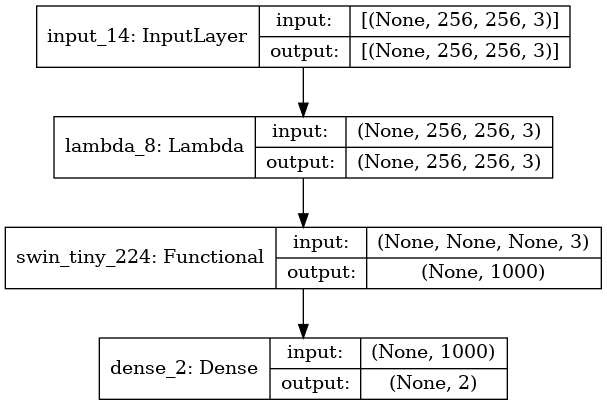

In [34]:
plot_model(model,show_shapes=True)

In [10]:
!ls

 cam1.ipynb		     swin.ipynb
 cam1_torch.ipynb	     temp_image.png
 cam2.ipynb		     temp_result.csv
 cam3.ipynb		     test.py
 cam4.ipynb		    'torch gradcam测试.ipynb'
 cam5.ipynb		     torchresult
 cam6.ipynb		     torch_train.py
 cam7.ipynb		     train
'cut patch 4.ipynb'	     测试集切patch.ipynb
'cut patch 4 - 副本.ipynb'   生成XML_good-Copy1.ipynb
 data			     生成XML_good.ipynb
 gradcamcode		     生成XML.ipynb
 keras_train.py		     训练.ipynb
 keras_vis		     训练-z490-Copy1.ipynb
 model.png		     评估-Copy2.ipynb
 result			     评估.ipynb
 rnn_torchviz		     评估可视化.ipynb
 rnn_torchviz.png	     量化评估-Copy1.ipynb
 saveed.pth		     量化评估.ipynb


In [ ]:
model.save("./50.h5")

In [61]:
tf.keras.Input(batch_size = 2,shape = (256,256, 3))

<KerasTensor: shape=(2, 256, 256, 3) dtype=float32 (created by layer 'input_16')>

In [38]:
model(tf.keras.Input(batch_size = 2,shape = (256,256, 3)))

<KerasTensor: shape=(2, 2) dtype=float32 (created by layer 'model_1')>

In [37]:
test_img = Image.open("./train/test/7_1/svs/21760_19200.png")
input_tensor = np.asarray(test_img)/255

In [40]:
model(np.expand_dims(input_tensor, 0))

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.5006086 , 0.49939138]], dtype=float32)>

In [34]:
gradcam_mask[y:y+patch_size,x:x+patch_size].shape

(0, 256, 3)

In [24]:
import keras

In [79]:
from keras_vis.gradcam import Gradcam


In [40]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from keras_vis.gradcam_plus_plus import GradcamPlusPlus
from keras_vis.utils.model_modifiers import ReplaceToLinear
from keras_vis.utils.scores import CategoricalScore
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.vgg16 import preprocess_input
from keras_vis.scorecam import Scorecam
from keras_vis.gradcam import Gradcam
from keras_vis.saliency import Saliency
from keras_vis.gradcam_plus_plus import GradcamPlusPlus

from keras.backend import set_session
from keras.backend import clear_session
from keras.backend import get_session
import gc

# Reset Keras Session
def reset_keras():
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    try:
        del classifier # this is from global space - change this as you need
    except:
        pass
    
    gc.collect()
#     print(gc.collect()) # if it's done something you should see a number being outputted

    # use the same config as you used to create the session
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    set_session(tf.compat.v1.Session(config=config))

In [108]:
tf.keras.backend.clear_session()

In [ ]:
# del model
model = keras.models.load_model('./result/vgg16_bad1/50-0.13.h5')

In [103]:
from keras import backend as K
K.clear_session()

In [41]:
reset_keras()

In [25]:
i

10

In [ ]:
for i in range(0,50):
    cam_result = copy.deepcopy(gradcam_3d(model, img3))

In [16]:
def evaluate():
    for i in range(0,5):
        cam_result = copy.deepcopy(gradcam_3d(model, img3))
    print(i)

In [ ]:
cam_result

In [22]:
import multiprocessing

process_eval = multiprocessing.Process(target=evaluate, args=())
process_eval.start()
process_eval.join()

In [55]:
gradcam_mask[y:y+patch_size,x:x+patch_size].shape

(512, 512, 3)

In [ ]:
images = np.asarray([np.array(img1), np.array(img2), np.array(img3)])

# Preparing input data for VGG16
X = preprocess_input(images)

cam = scorecam(score, X, penultimate_layer=-1)

heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)

In [27]:
X.shape

(3, 256, 256, 3)

In [47]:
temp_cam = gradcam_3d(model, img3)

In [51]:
temp_cam.shape

(256, 256, 3)

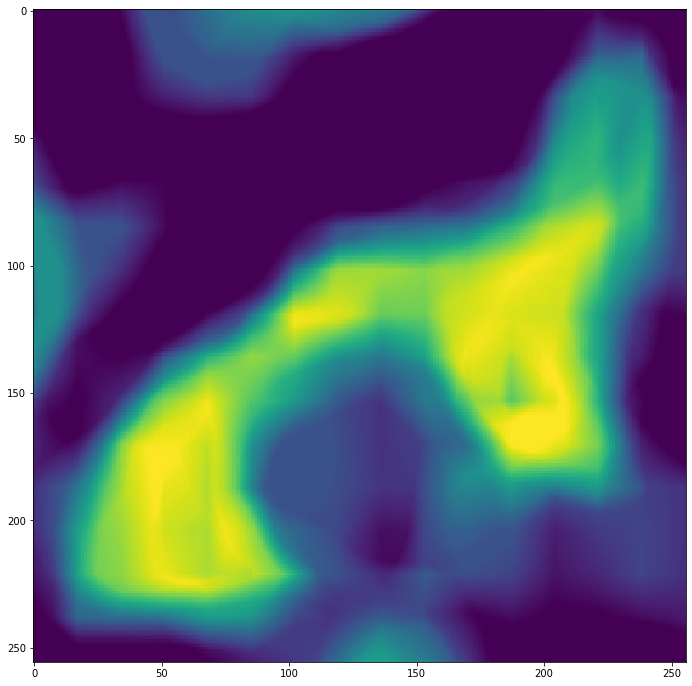

In [49]:
plt.figure(figsize=(12,12))
plt.imshow(temp_cam[...,0], interpolation='nearest')
plt.show()
# imshow(temp_cam_all[...,2], cmap='jet', alpha=1)

# plt.show()

TypeError: 'AxesSubplot' object does not support indexing

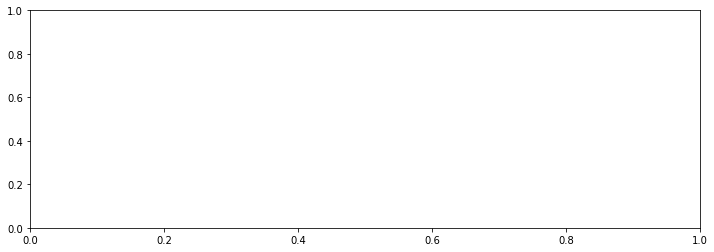

In [37]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))

for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
#     ax[i].imshow(images[i])
    ax[i].imshow(temp_cam_all[...,2], cmap='jet', alpha=1)
    ax[i].axis('off')
plt.tight_layout()
plt.show()


In [30]:
temp_cam[1][...,2]

array([[127., 127., 127., ..., 232., 227., 218.],
       [127., 127., 127., ..., 236., 227., 218.],
       [127., 127., 127., ..., 236., 227., 218.],
       ...,
       [255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.],
       [255., 255., 255., ..., 255., 255., 255.]])

In [31]:
timg1 = np.asarray(img1)

#     images = np.asarray([np.array(img1), np.array(np.flip(timg1,0)), np.array(np.rollaxis(timg1,0,2)), np.array(np.rot90(timg1,2))])

#     images = np.asarray([np.array(img1), np.array(img2), np.array(img3)])

# Preparing input data for VGG16
#     X = preprocess_input(images)

testarray = np.zeros((4, timg1.shape[0], timg1.shape[1], timg1.shape[2]) ,dtype=np.uint8)
testarray[0] = timg1 #原图
testarray[1] = (np.flip(timg1,0))
testarray[2] = np.rollaxis(timg1,0,2)
testarray[3] = (np.rot90(timg1,2))

X = np.asarray(testarray)
#     print(testarray.shape)

#     X = preprocess_input(images)
#     print(X.shape)



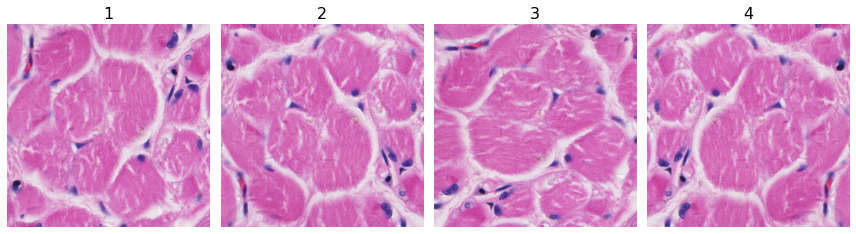

In [37]:
f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(X[i])
    ax[i].axis('off')
plt.tight_layout()
plt.show()

In [38]:
gradcam = Gradcam(model,
                  model_modifier=replace2linear,
                  clone=True)

# Generate heatmap with GradCAM
cam = gradcam(score,
              X,
              penultimate_layer=-1)

# aa[0] = np.uint8(cm.jet(cam[0])[..., :3] * 255)
# aa[1] = np.flip((np.uint8(cm.jet(cam[1])[..., :3] * 255)),0)   
# aa[2] = np.rollaxis(np.uint8(cm.jet(cam[2])[..., :3] * 255),0,2)
# aa[3] = np.rot90((np.uint8(cm.jet(cam[3])[..., :3] * 255)),2)

In [56]:
def detection_3d(model1,timg1,m,temp_channel =1 ):

#     timg = Image.fromarray((test_img))
#     timg1 = np.array(timg)
    
    testarray = [[] for i in range(4)]
    testarray[0] = timg1 #原图
    testarray[1] = (np.flip(timg1,0))
    testarray[2] = np.rollaxis(timg1,0,2)
    testarray[3] = (np.rot90(timg1,2))
    
    
    testarray = np.asarray(testarray)
#     print(testarray.shape)
    
#     aa = modeleva_3d(model1,testarray)
#     aa[aa>th] = 125
#     aa[aa!=125] = 0

#     aa = np.asarray(np.transpose(aa,(0,2,3,1)).reshape(aa.shape[0],aa.shape[2],aa.shape[3],3))
    aa = np.zeros((4), dtype = np.object)
    
    aa[0] = modeleva_3d(model1,testarray[0],temp_channel) + m
    aa[1] = np.flip((modeleva_3d(model1,testarray[1],temp_channel)),0)   + m
    aa[2] = np.rollaxis(modeleva_3d(model1,testarray[2],temp_channel),0,2) + m
    aa[3] = np.rot90((modeleva_3d(model1,testarray[3],temp_channel)),2) + m
    
    aa = aa[0] + aa[1] + aa[2] + aa[3]
    aa = aa/4
    
    return aa

In [11]:
gradcam_3d(model, img1)

NameError: name 'preprocess_input' is not defined

In [55]:
def detection_3d(model1,timg1,m):

#     timg = Image.fromarray((test_img))
#     timg1 = np.array(timg)
    
    testarray = [[] for i in range(2)]
    testarray[0] = timg1 #原图
    testarray[1] = (np.flip(timg1,0))
#     testarray[2] = np.rollaxis(timg1,0,2)
#     testarray[3] = (np.rot90(timg1,2))
    
    testarray = np.asarray(testarray)
#     print(testarray.shape)
    
#     aa = modeleva_3d(model1,testarray)
#     aa[aa>th] = 125
#     aa[aa!=125] = 0

#     aa = np.asarray(np.transpose(aa,(0,2,3,1)).reshape(aa.shape[0],aa.shape[2],aa.shape[3],3))
    aa = np.zeros((2), dtype = np.object)
    
    aa[0] = modeleva_3d(model1,testarray[0],opchannel-1) + m
    aa[1] = np.flip((modeleva_3d(model1,testarray[1],opchannel-1)),0)   + m
#     aa[2] = np.rollaxis(modeleva_3d(model1,testarray[3]),0,2)
#     aa[3] = np.rot90((modeleva_3d(model1,testarray[4])),2)
    
    return aa